# 3D CNN over 11x11 single-station-sub-rasters, leaving out the worst stations
** Features: Precipitation, Mean-Air-Temperature **

Ausgabe: Veränderung Messstand 4 Wochen nach letztem Messstand zu letztem Messstand

Eingabe:
- 11x11 (ca. 11kx11km) Raster wöchentlich summierter Niederschlag für 8 Wochen vor letztem Messstand und vorhergesagter für die 4 Wochen nach letztem Messstand
- 11x11 monatl. Durchschnittstemperatur für die 3 vorkommenden Monate
- letzter Messstand und Messstand 4 Wochen davor, jeweils als Veränderung zu 4 Wochen davor

In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
import datetime


%load_ext tensorboard

In [2]:
data_drive = r'F:/'

## 1. load Data

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'

rws_files = glob.glob(rws_folder+'*2008*.tif') + glob.glob(rws_folder+'*2009*.tif') + glob.glob(rws_folder+'*2010*.tif') + glob.glob(rws_folder+'*2011*.tif') + glob.glob(rws_folder+'*2012*.tif') +glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files.sort()
temp_folder = data_drive + r'GruV-Net/data/temperature/GTiff/'

In [5]:
def assemble_instances(regnie_files, temp_path):
    x_regnie = []
    x_temp = []
    x_gw = []
    y = []
    instances_list = []

    worst_stations = ['HE_15725', 'HE_5099', 'HE_10319']

    regnie_file_names = list(map(os.path.basename, regnie_files))

    for i in range(0, len(regnie_files)-11):
        regnie_srcs =  []
        for l in range(0,12):
            #print(regnie_files[i+l])
            regnie_srcs.append(rio.open(regnie_files[i+l]))
        temp_srcs = []
        for l in (2, 6, 10):
            #Monatsauswahl noch tricky
            #print(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif')
            temp_srcs.append(rio.open(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif'))

        stations = gw_weekly.loc[regnie_file_names[i][4:14], : ].dropna().index.tolist()
        for s in stations:
            if s in worst_stations: continue

            instance_desc = []
            instance_desc.append(s)
            east = stammdaten.loc[s]['OSTWERT']
            north = stammdaten.loc[s]['NORDWERT']
            row, col = regnie_srcs[0].index(east, north)

            instance_regnie = np.ndarray(shape=(12,11,11,1))
            # das ist noch ein Problem, manche Stationen zu nah am Rand
            try:
                for j in range(12):
                    r = regnie_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_regnie[j] = r.reshape((11,11,1))
                    instance_desc.append(regnie_srcs[j].name[48:-4])
            except ValueError:
                continue

            instance_temp = np.ndarray(shape=(3,11,11,1))
            try:
                for j in range(3):
                    r = temp_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_temp[j] = r.reshape((11,11,1))
                    instance_desc.append(temp_srcs[j].name[35:-4])
            except ValueError:
                continue

            instance_gw = []
            try:    
                for k in [0, 4, 8]:
                    #lieber in Prozent?
                    change =  gw_weekly.loc[regnie_file_names[i+k+4][4:14], : ][s] - gw_weekly.loc[regnie_file_names[i+k][4:14], : ][s]
                    if np.isnan(change):
                        raise Exception()
                    else: 
                        instance_gw = np.append(instance_gw, change)
                        instance_desc.append(regnie_file_names[i+k+4][4:14])
                        instance_desc.append(change)
            except Exception:
                continue 

            x_regnie.append(instance_regnie)
            x_temp.append(instance_temp)
            x_gw.append(instance_gw[:2])
            instances_list.append(instance_desc)
            y = y + list(instance_gw[2:])
    return np.array(x_regnie), np.array(x_temp), np.array(x_gw), np.array(y), instances_list

In [14]:
X_regnie, X_temp, X_gw, y, instances_list = assemble_instances(rws_files, temp_folder)

In [7]:
#pd.DataFrame(instances_list)

In [7]:
print(X_regnie.shape)
print(X_temp.shape)
print(X_gw.shape)
print(y.shape)

(225605, 12, 11, 11, 1)
(225605, 3, 11, 11, 1)
(225605, 2)
(225605,)


In [10]:
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_wo-worst.npy', X_regnie)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_temp_2008-2017_wo-worst.npy', X_temp)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_gw_2008-2017_wo-worst.npy', X_gw)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/Y_2008-2017_wo-worst.npy', y)

## 2. Define and train CNN

In [3]:
X_regnie = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_wo-worst.npy')
X_temp = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_temp_2008-2017_wo-worst.npy')
#X_gw = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_gw_2008-2017_wo-worst.npy')
y = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/y_2008-2017_wo-worst.npy')

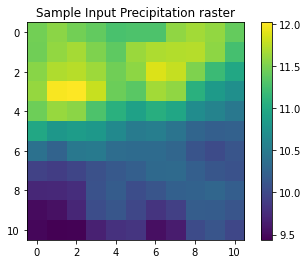

In [4]:
plt.imshow(X_regnie[0][0].reshape((11,11)))
plt.title("Sample Input Precipitation raster")
plt.colorbar()

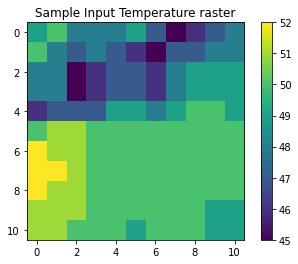

In [5]:
plt.imshow(X_temp[0][0].reshape((11,11)))
plt.title("Sample Input Temperature raster")
plt.colorbar()

In [6]:
regnie_input = keras.Input(shape=(12, 11, 11, 1), name="regnie")
temp_input = keras.Input(shape=(3, 11, 11, 1), name="temp")

regnie_features = layers.Conv3D(64, 3, data_format='channels_last')(regnie_input)
regnie_features = layers.MaxPooling3D(pool_size=(3))(regnie_features)
regnie_features = layers.Flatten()(regnie_features)
temp_features = layers.Conv3D(64, (1,3,3), data_format='channels_last')(temp_input)
temp_features = layers.MaxPooling3D(pool_size=(1,3,3))(temp_features)
temp_features = layers.Flatten()(temp_features)
env_features = layers.concatenate([regnie_features, temp_features])
env_features = layers.Dense(64)(env_features)
x = layers.Dense(32)(env_features)
pred = layers.Dense(1)(x)

GruV = keras.Model(
    inputs=[regnie_input, temp_input],
    outputs=[pred],
)

In [7]:
GruV.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])
GruV.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
regnie (InputLayer)             [(None, 12, 11, 11,  0                                            
__________________________________________________________________________________________________
temp (InputLayer)               [(None, 3, 11, 11, 1 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 10, 9, 9, 64) 1792        regnie[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 3, 9, 9, 64)  640         temp[0][0]                       
______________________________________________________________________________________________

In [8]:
hist = []
cv_round = 1

for train_idx, test_idx in TimeSeriesSplit(5).split(X_regnie):
    X_regnie_train, X_regnie_test = X_regnie[train_idx], X_regnie[test_idx]
    X_temp_train, X_temp_test = X_temp[train_idx], X_temp[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    regnie_scaler = preprocessing.StandardScaler().fit(X_regnie_train.reshape(*X_regnie_train.shape[:1], -1))
    temp_scaler = preprocessing.StandardScaler().fit(X_temp_train.reshape(*X_temp_train.shape[:1], -1))

    X_regnie_train = regnie_scaler.transform(X_regnie_train.reshape(*X_regnie_train.shape[:1], -1)).reshape((len(train_idx), 12, 11, 11, 1))
    X_regnie_test = regnie_scaler.transform(X_regnie_test.reshape(*X_regnie_test.shape[:1], -1)).reshape((len(test_idx), 12, 11, 11, 1))
    X_temp_train = temp_scaler.transform(X_temp_train.reshape(*X_temp_train.shape[:1], -1)).reshape((len(train_idx), 3, 11, 11, 1))
    X_temp_test = temp_scaler.transform(X_temp_test.reshape(*X_temp_test.shape[:1], -1)).reshape((len(test_idx), 3, 11, 11, 1))

    h = GruV.fit(
    {"regnie": X_regnie_train, "temp": X_temp_train},
    y_train,
    epochs=20,
    validation_data=({"regnie": X_regnie_test, "temp": X_temp_test}, y_test),
    )

    hist.append(h)
    cv_round += 1

_mean_absolute_error: 0.2894 - val_root_mean_squared_error: 0.5395
Train on 75205 samples, validate on 37600 samples
Epoch 1/20
75205/75205 [==============================] - 112s 1ms/sample - loss: 0.2637 - mean_absolute_error: 0.2552 - root_mean_squared_error: 0.5135 - val_loss: 0.2805 - val_mean_absolute_error: 0.2561 - val_root_mean_squared_error: 0.5296
Epoch 2/20
75205/75205 [==============================] - 201s 3ms/sample - loss: 0.2623 - mean_absolute_error: 0.2546 - root_mean_squared_error: 0.5122 - val_loss: 0.2749 - val_mean_absolute_error: 0.2473 - val_root_mean_squared_error: 0.5243
Epoch 3/20
75205/75205 [==============================] - 201s 3ms/sample - loss: 0.2617 - mean_absolute_error: 0.2544 - root_mean_squared_error: 0.5116 - val_loss: 0.2819 - val_mean_absolute_error: 0.2552 - val_root_mean_squared_error: 0.5309
Epoch 4/20
75205/75205 [==============================] - 202s 3ms/sample - loss: 0.2608 - mean_absolute_error: 0.2538 - root_mean_squared_error: 0.510

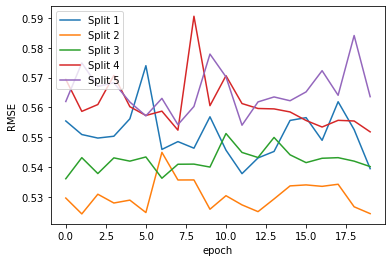

In [9]:
for i in range(5):
    plt.plot(hist[i].history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['Split 1', 'Split 2', 'Split 3', 'Split 4', 'Split 5'], loc='upper left')
plt.show()